In [2]:
# --- Step 1: Authenticate and Set Up BigQuery Client ---

# This command will ask you to sign in to your Google account to get permission
# to access the Google Cloud project.
from google.colab import auth
auth.authenticate_user()

# Import the BigQuery library and create a "client"
# The client is your tool for talking to the BigQuery database.
from google.cloud import bigquery
client = bigquery.Client(project='sccm-datathon-2025-participant')

print("✅ Authentication successful and BigQuery client is ready!")


# --- Step 2: Load a Table into a Pandas DataFrame ---
# We'll load the 'Annotations' table as it's full of great data for visualization.

dataset_id = 'AutoDoc'
table_id = 'Annotations'

# This is a SQL query that asks for everything in the Annotations table.
query = f"SELECT * FROM `sccm-discovery.{dataset_id}.{table_id}`"

# This line sends the query to BigQuery and loads the result into a 'DataFrame'.
# A DataFrame is the standard table format used for data analysis in Python.
annotations_df = client.query(query).to_dataframe()

print(f"\nSuccessfully loaded the '{table_id}' table.")
print("Here's a preview of the data:")
display(annotations_df.head())

✅ Authentication successful and BigQuery client is ready!

Successfully loaded the 'Annotations' table.
Here's a preview of the data:


,file_id,task,ictl_number,skill_start_time_hh:mm:ss,skill_end_time_hh:mm:ss,time_on_task,notes,medication,dosage,route,body_location,anatomical_location,sagittal_location,provider,casualty,abandonment,reviewer_initials,date_mm_dd_yyyy
0,42,StartEx,None,00:00:00,00:00:10,00:00:10,None,None,None,None,None,None,None,<NA>,<NA>,<NA>,JS,1/8/2024
1,42,Time Sync,None,00:00:09,00:00:09,00:00:00,None,None,None,None,None,None,None,<NA>,<NA>,<NA>,JS,1/8/2024
2,42,Tourniquet Application,081-000-0048,00:00:15,00:01:01,00:00:46,None,None,None,None,Thigh,Anterior,Right,<NA>,<NA>,<NA>,JS,1/8/2024
3,42,Nasopharyngeal Airway,081-COM-1023,00:01:17,00:01:31,00:00:14,None,None,None,None,None,None,None,<NA>,<NA>,<NA>,JS,1/8/2024
4,42,Chest Seal Application,081-COM-0069,00:01:45,00:02:05,00:00:20,First seal applied at 00:02:04. Applied back s...,None,None,None,Chest,Anterior,Left,<NA>,<NA>,<NA>,JS,1/8/2024


The actual column names in the 'Annotations' table are:
--------------------------------------------------
['file_id', 'task', 'ictl_number', 'skill_start_time_hh:mm:ss', 'skill_end_time_hh:mm:ss', 'time_on_task', 'notes', 'medication', 'dosage', 'route', 'body_location', 'anatomical_location', 'sagittal_location', 'provider', 'casualty', 'abandonment', 'reviewer_initials', 'date_mm_dd_yyyy']


/tmp/ipython-input-4-607712396.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


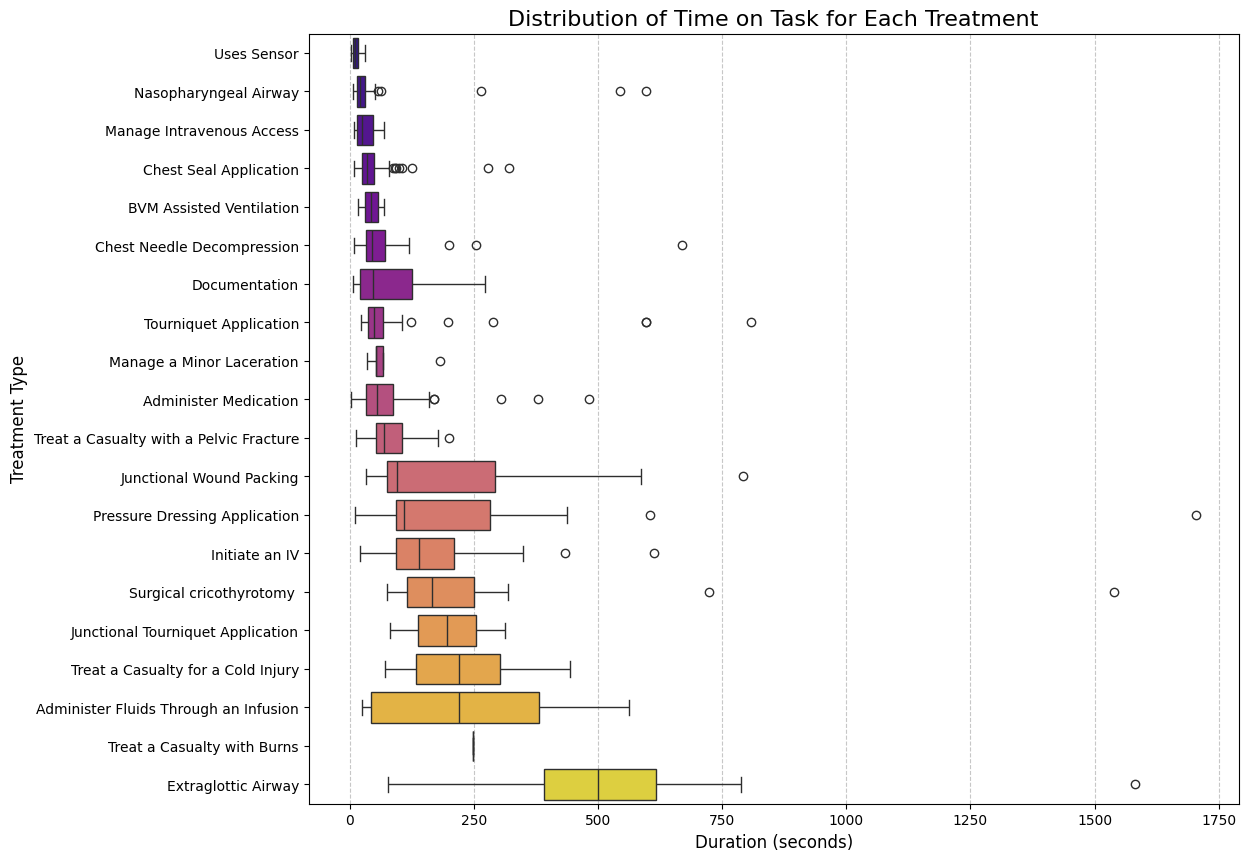

In [4]:
# --- Step 1: Discover the Actual Column Names ---

# Ensure your DataFrame is loaded. If not, run the query cell again.
# query = "SELECT * FROM `sccm-discovery.AutoDoc.Annotations`"
# annotations_df = client.query(query).to_dataframe()

print("The actual column names in the 'Annotations' table are:")
print("-" * 50)
# The .columns attribute gives you a list of all column names.
print(annotations_df.columns.tolist())

# --- Visualization 1 (Corrected): Time on Task Box Plot ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- THE FIX ---
# We are now using the exact column names you discovered.
CORRECT_START_TIME_COLUMN = 'skill_start_time_hh:mm:ss'
CORRECT_END_TIME_COLUMN = 'skill_end_time_hh:mm:ss'

# Convert the time columns from text to a proper time format.
annotations_df['start_time'] = pd.to_datetime(annotations_df[CORRECT_START_TIME_COLUMN], format='%H:%M:%S', errors='coerce')
annotations_df['end_time'] = pd.to_datetime(annotations_df[CORRECT_END_TIME_COLUMN], format='%H:%M:%S', errors='coerce')

# Calculate the duration of each task in seconds.
annotations_df['duration_seconds'] = (annotations_df['end_time'] - annotations_df['start_time']).dt.total_seconds()

# Filter out bad data and administrative tasks.
# We also use the correct lowercase 'task' column name here.
sensible_durations_df = annotations_df[
    (annotations_df['duration_seconds'] > 0) &
    (~annotations_df['task'].isin(['StartEx', 'Time Sync', 'ENDEX']))
].copy()

# Create the box plot
plt.figure(figsize=(12, 10))
sns.boxplot(
    x='duration_seconds',
    y='task',
    data=sensible_durations_df,
    palette='plasma',
    order=sensible_durations_df.groupby('task')['duration_seconds'].median().sort_values().index
)

plt.title('Distribution of Time on Task for Each Treatment', fontsize=16)
plt.xlabel('Duration (seconds)', fontsize=12)
plt.ylabel('Treatment Type', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [21]:
annotations_df

,file_id,task,ictl_number,skill_start_time_hh:mm:ss,skill_end_time_hh:mm:ss,time_on_task,notes,medication,dosage,route,...,sagittal_location,provider,casualty,abandonment,reviewer_initials,date_mm_dd_yyyy,start_time,end_time,duration_seconds,start_seconds
0,42,StartEx,None,00:00:00,00:00:10,00:00:10,None,None,None,None,...,None,<NA>,<NA>,<NA>,JS,1/8/2024,1900-01-01 00:00:00,1900-01-01 00:00:10,10.0,0.0
1,42,Time Sync,None,00:00:09,00:00:09,00:00:00,None,None,None,None,...,None,<NA>,<NA>,<NA>,JS,1/8/2024,1900-01-01 00:00:09,1900-01-01 00:00:09,0.0,9.0
2,42,Tourniquet Application,081-000-0048,00:00:15,00:01:01,00:00:46,None,None,None,None,...,Right,<NA>,<NA>,<NA>,JS,1/8/2024,1900-01-01 00:00:15,1900-01-01 00:01:01,46.0,15.0
3,42,Nasopharyngeal Airway,081-COM-1023,00:01:17,00:01:31,00:00:14,None,None,None,None,...,None,<NA>,<NA>,<NA>,JS,1/8/2024,1900-01-01 00:01:17,1900-01-01 00:01:31,14.0,77.0
4,42,Chest Seal Application,081-COM-0069,00:01:45,00:02:05,00:00:20,First seal applied at 00:02:04. Applied back s...,None,None,None,...,Left,<NA>,<NA>,<NA>,JS,1/8/2024,1900-01-01 00:01:45,1900-01-01 00:02:05,20.0,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,22,Chest Seal Application,081-COM-0069,00:01:17,00:02:13,00:00:56,None,None,None,None,...,Right,<NA>,<NA>,<NA>,JS,29-Mar-24,1900-01-01 00:01:17,1900-01-01 00:02:13,56.0,77.0
809,22,Nasopharyngeal Airway,081-COM-1023,00:02:54,00:03:04,00:00:10,None,None,None,None,...,Right,<NA>,<NA>,<NA>,JS,29-Mar-24,1900-01-01 00:02:54,1900-01-01 00:03:04,10.0,174.0
810,22,Junctional Wound Packing,081-68W-0081,00:03:14,00:04:35,00:01:21,No stop cue. End of video.,None,None,None,...,Left,<NA>,<NA>,True,JS,29-Mar-24,1900-01-01 00:03:14,1900-01-01 00:04:35,81.0,194.0
811,22,Pressure Dressing Application,081-000-0110,00:04:25,00:04:35,00:00:10,No stop cue reached. End of the video./Did not...,None,None,None,...,Left,<NA>,<NA>,True,JS,2-Apr-24,1900-01-01 00:04:25,1900-01-01 00:04:35,10.0,265.0


/tmp/ipython-input-6-2626831469.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipython-input-6-2626831469.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


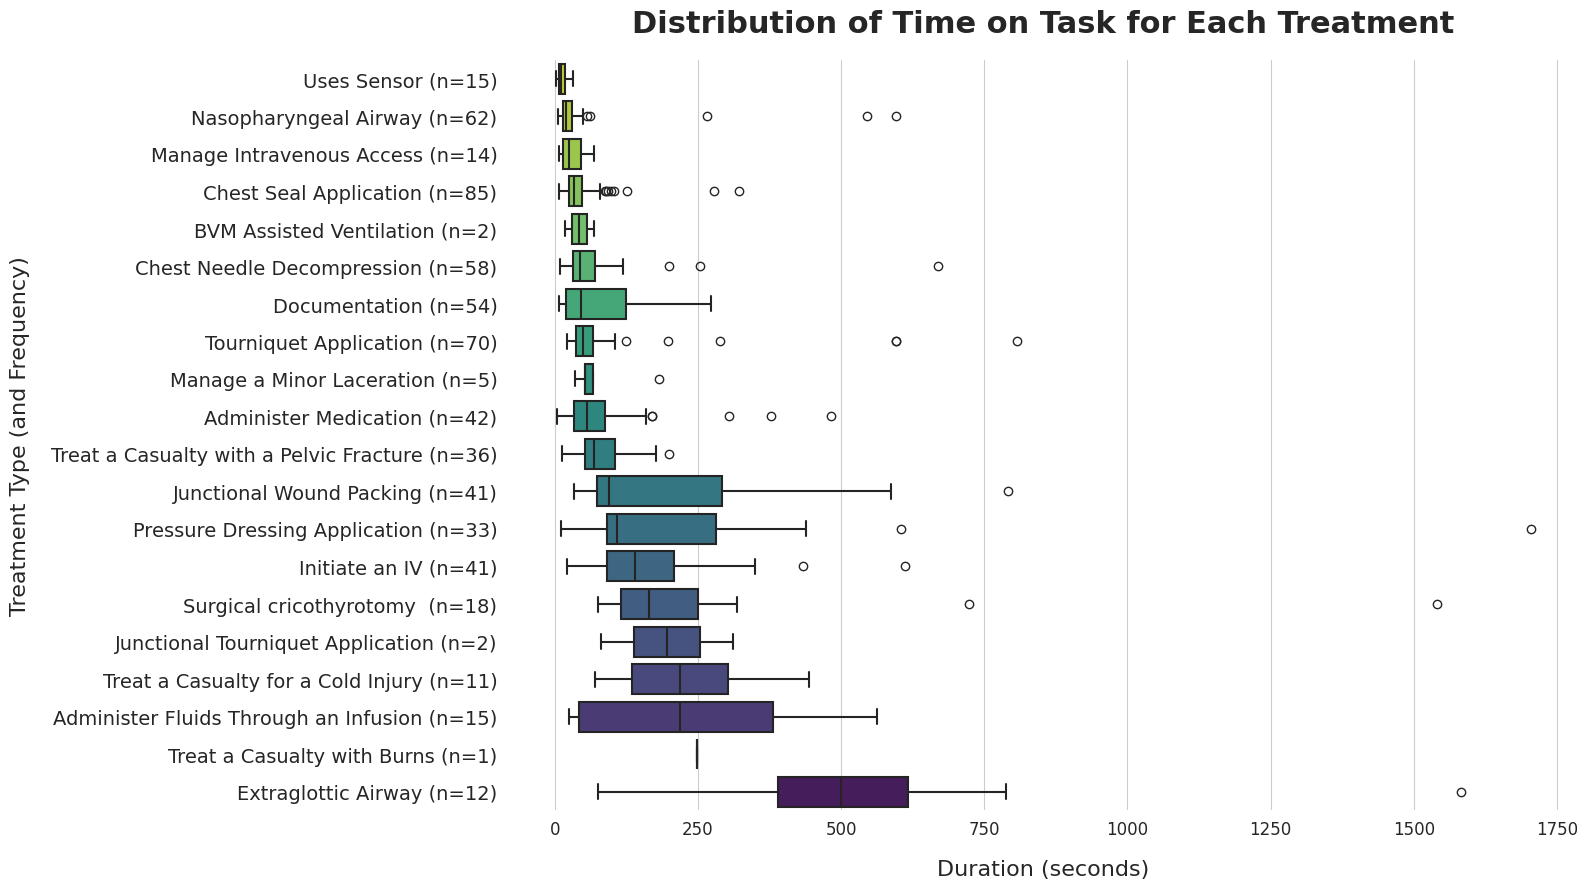

In [6]:
# --- Final, Corrected Visualization: Time on Task Box Plot ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Part 1: Data Preparation (Same as before) ---
# Ensure your annotations_df is loaded and the time columns are calculated

CORRECT_START_TIME_COLUMN = 'skill_start_time_hh:mm:ss'
CORRECT_END_TIME_COLUMN = 'skill_end_time_hh:mm:ss'

annotations_df['start_time'] = pd.to_datetime(annotations_df[CORRECT_START_TIME_COLUMN], format='%H:%M:%S', errors='coerce')
annotations_df['end_time'] = pd.to_datetime(annotations_df[CORRECT_END_TIME_COLUMN], format='%H:%M:%S', errors='coerce')
annotations_df['duration_seconds'] = (annotations_df['end_time'] - annotations_df['start_time']).dt.total_seconds()

sensible_durations_df = annotations_df[
    (annotations_df['duration_seconds'] > 0) &
    (~annotations_df['task'].isin(['StartEx', 'Time Sync', 'ENDEX']))
].copy()


# --- Part 2: Prepare Labels with Frequency Counts ---

# Calculate the frequency of each task
task_counts = sensible_durations_df['task'].value_counts()

# Order the tasks by their median duration
ordered_tasks = sensible_durations_df.groupby('task')['duration_seconds'].median().sort_values().index

# --- THIS IS THE NEW, CLEANER METHOD ---
# Create a new list of labels that includes the count, like "Tourniquet Application (n=54)"
new_labels = [f"{task} (n={task_counts.get(task, 0)})" for task in ordered_tasks]


# --- Part 3: Create the Plot (Robust Method) ---

# Set style and figure size
sns.set_style("whitegrid")
plt.figure(figsize=(16, 9))

# Create the box plot using the standard, reliable method
# Seaborn will handle all the drawing and coloring automatically.
ax = sns.boxplot(
    x='duration_seconds',
    y='task',
    data=sensible_durations_df,
    order=ordered_tasks, # Use the ordered list
    palette='viridis_r', # A nice, visually distinct color palette
    linewidth=1.5
)

# --- Part 4: Final Touches (Labels, Titles, etc.) ---

# Set the y-axis labels to our new, combined labels
ax.set_yticklabels(new_labels)

# Increase font sizes for readability
plt.title('Distribution of Time on Task for Each Treatment', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Duration (seconds)', fontsize=16, labelpad=15)
plt.ylabel('Treatment Type (and Frequency)', fontsize=16, labelpad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14) # Make the task labels a bit larger

# Clean up the final look
sns.despine(left=True, bottom=True)
plt.tight_layout() # Adjust layout to make sure everything fits
plt.show()

/tmp/ipython-input-27-2082613464.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.values, y=location_counts.index, palette='viridis')


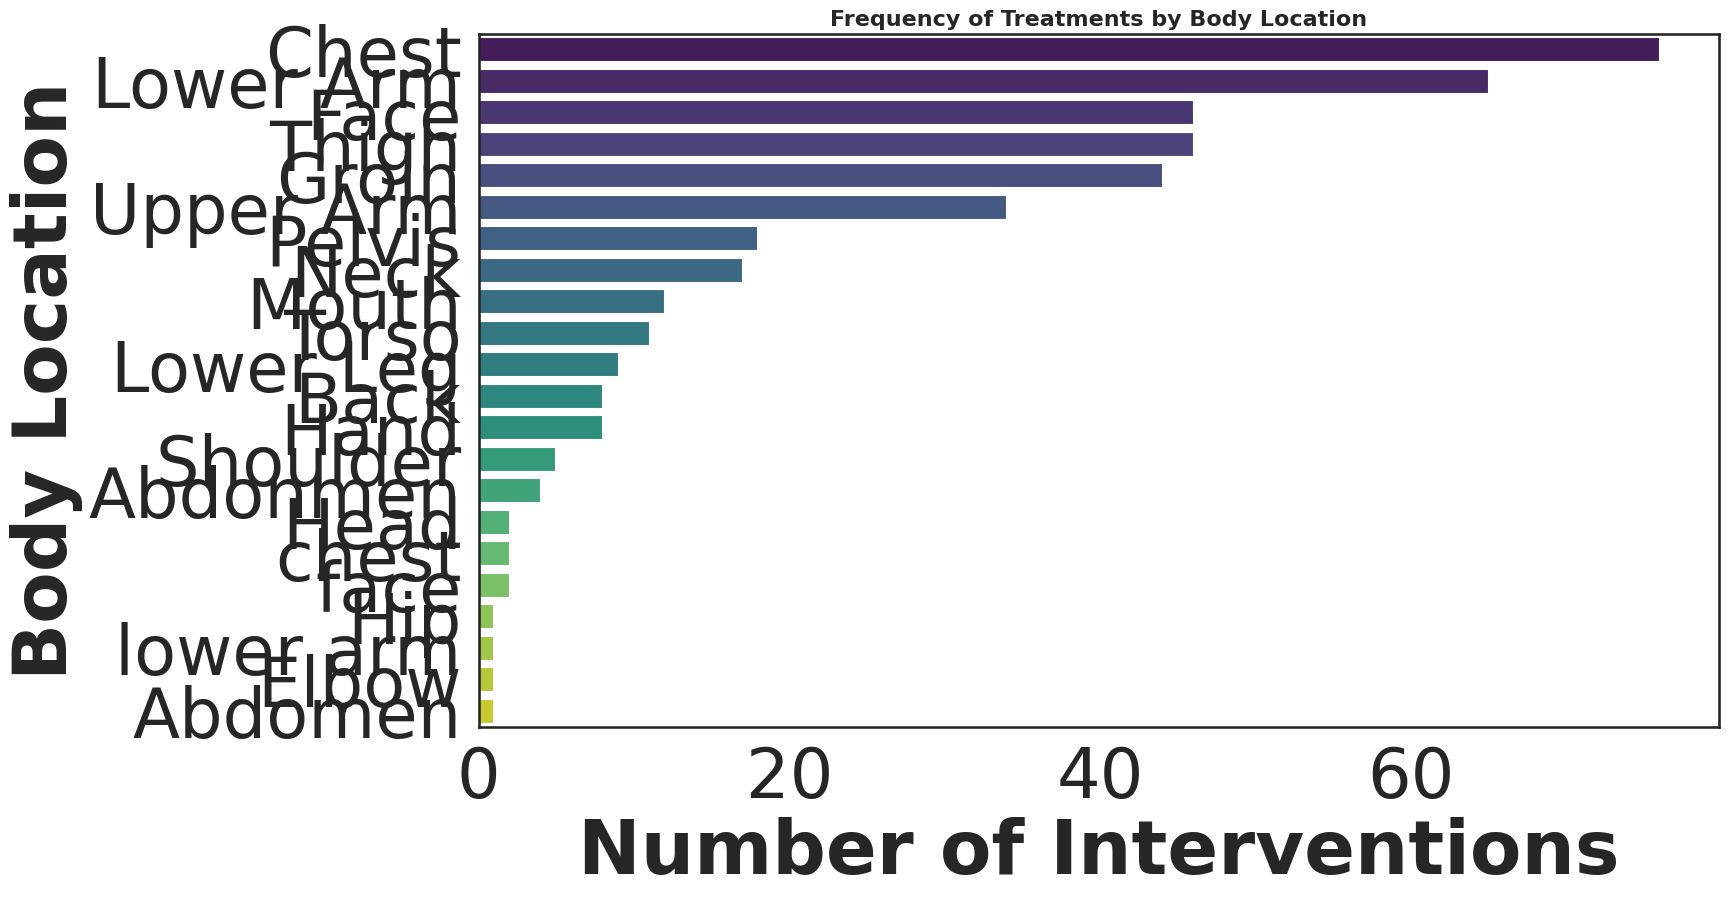

In [27]:
# --- Visualization 2 (Corrected): Treatments by Body Location ---

# --- THE FIX ---
# Use the correct lowercase 'body_location' column name.
location_counts = annotations_df['body_location'].dropna().value_counts()

# Create the bar chart
plt.figure(figsize=(16, 9))
sns.barplot(x=location_counts.values, y=location_counts.index, palette='viridis')

plt.title('Frequency of Treatments by Body Location', fontsize=16)
plt.xlabel('Number of Interventions')
plt.ylabel('Body Location')
plt.show()

/tmp/ipython-input-31-2803045208.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.values, y=location_counts.index, palette='viridis')


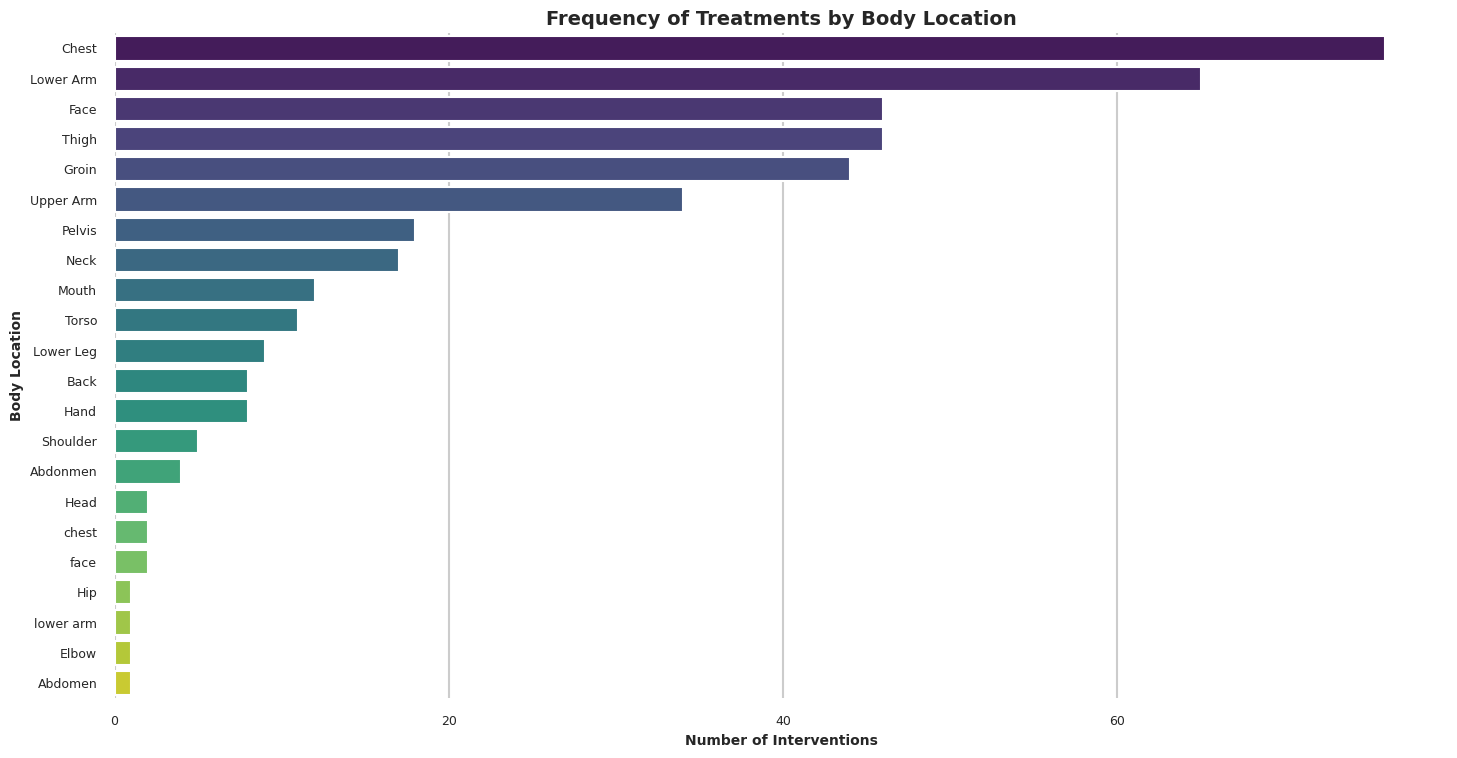

In [31]:
# --- Visualization 2 (Corrected with Smaller Fonts): Treatments by Body Location ---

import matplotlib.pyplot as plt
import seaborn as sns

# --- THE FIX ---
# Use the correct lowercase 'body_location' column name.
location_counts = annotations_df['body_location'].dropna().value_counts()

# --- Style and Figure Setup ---
sns.set_style("whitegrid") # Use a clean grid style
plt.figure(figsize=(16, 9)) # A slightly more compact figure size

# Create the bar chart
sns.barplot(x=location_counts.values, y=location_counts.index, palette='viridis')

# --- THIS IS THE FIX FOR YOUR REQUEST ---
# Set all font sizes to smaller, controlled values
plt.title('Frequency of Treatments by Body Location', fontsize=14)
plt.xlabel('Number of Interventions', fontsize=10)
plt.ylabel('Body Location', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
# ------------------------------------

# --- Final Touches for a Cleaner Look ---
sns.despine(left=True, bottom=True) # Remove unnecessary borders
plt.tight_layout() # Adjust plot to ensure everything fits
plt.show()



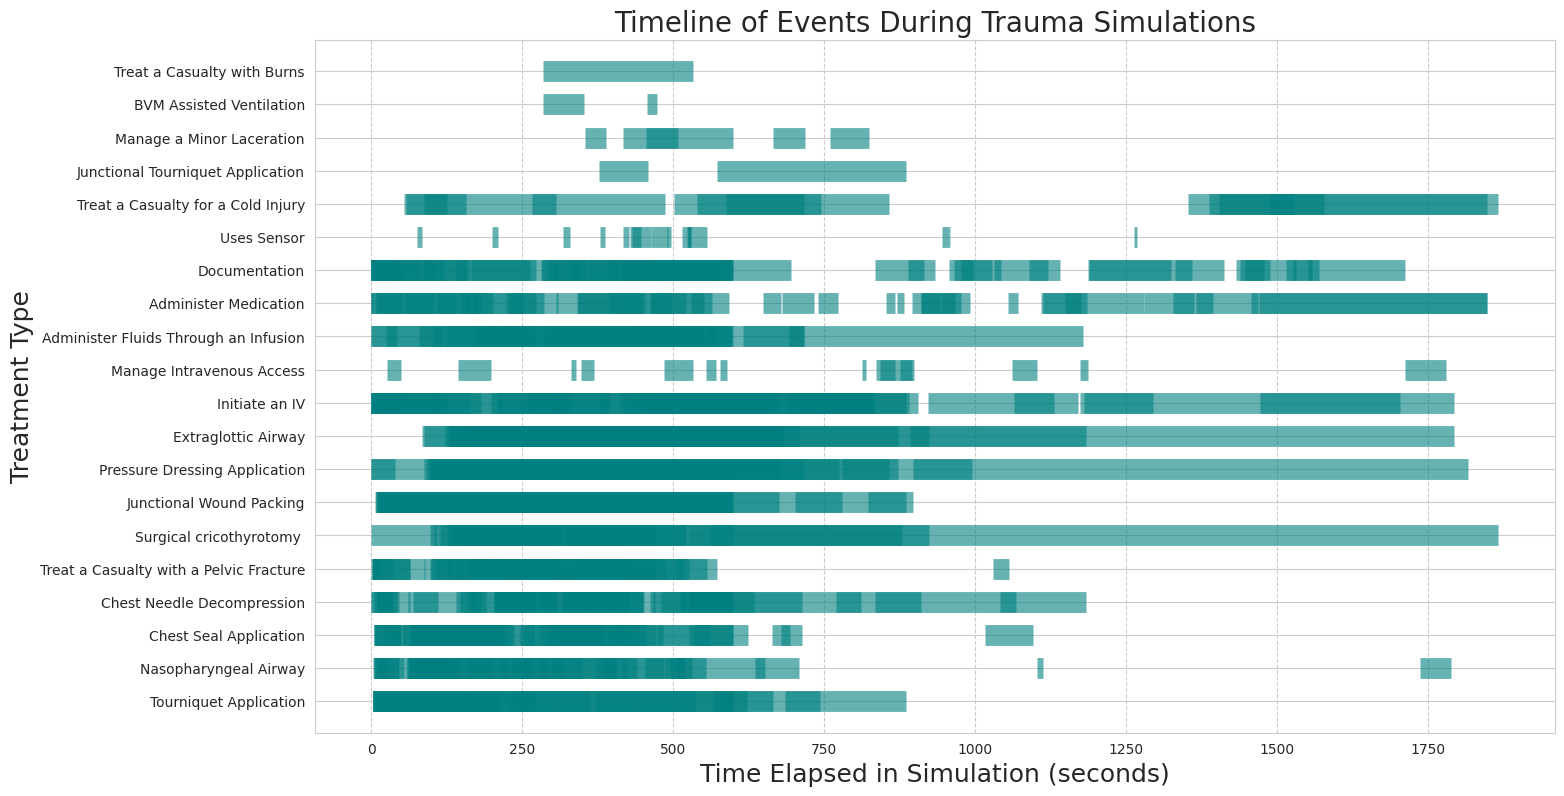

In [8]:
# --- Visualization 3 (Corrected): Simulation Timeline Plot ---

# We need the start time in seconds, which we calculated in the first visualization cell.
annotations_df['start_seconds'] = (annotations_df['start_time'] - pd.to_datetime('00:00:00', format='%H:%M:%S')).dt.total_seconds()

# Filter for the same sensible tasks using the correct 'task' column name.
timeline_df = annotations_df[
    (annotations_df['duration_seconds'] > 0) &
    (~annotations_df['task'].isin(['StartEx', 'Time Sync', 'ENDEX']))
].copy()

# Create the plot
plt.figure(figsize=(16, 9))
plt.hlines(
    y=timeline_df['task'],
    xmin=timeline_df['start_seconds'],
    xmax=timeline_df['start_seconds'] + timeline_df['duration_seconds'],
    linewidth=15,
    alpha=0.6,
    color='teal'
)

plt.title('Timeline of Events During Trauma Simulations', fontsize=20)
plt.xlabel('Time Elapsed in Simulation (seconds)', fontsize=18)
plt.ylabel('Treatment Type', fontsize=18)
plt.grid(axis='x', linestyle='--')
plt.show()

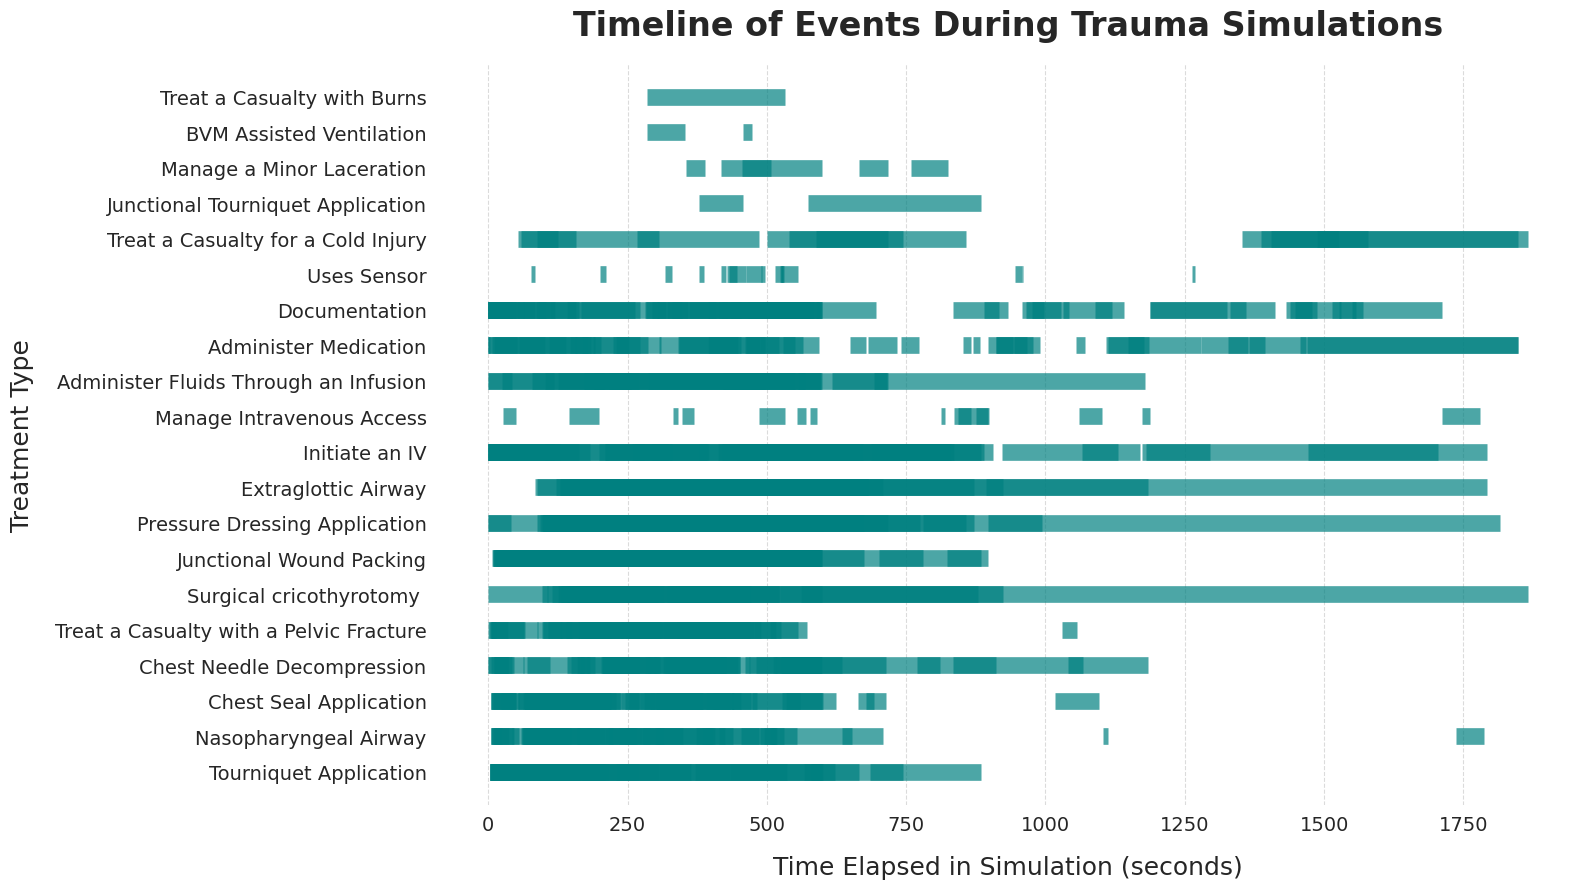

In [12]:
# --- Visualization 3 (Prettier): Simulation Timeline Plot ---

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Part 1: Data Preparation (Same as before) ---
# We need the start time in seconds, which we calculated in a previous cell.
annotations_df['start_seconds'] = (annotations_df['start_time'] - pd.to_datetime('00:00:00', format='%H:%M:%S')).dt.total_seconds()

# Filter for the same sensible tasks using the correct 'task' column name.
timeline_df = annotations_df[
    (annotations_df['duration_seconds'] > 0) &
    (~annotations_df['task'].isin(['StartEx', 'Time Sync', 'ENDEX']))
].copy()


# --- Part 2: Prepare for Prettier Plotting ---

# Set the visual style for a professional look
sns.set_style("whitegrid")

# Get a sorted, unique list of tasks for the y-axis
sorted_tasks = sorted(timeline_df['task'].unique())

# Create a color palette with a unique color for each task
palette = sns.color_palette("viridis", n_colors=len(sorted_tasks))
color_map = dict(zip(sorted_tasks, palette))

# Add a 'color' column to our data for easy plotting
timeline_df['color'] = timeline_df['task'].map(color_map)

sns.set_style("white")

# --- Part 3: Create the Plot ---

plt.figure(figsize=(16, 9)) # Made the plot taller to give labels more space

# Plot the horizontal lines (events)
plt.hlines(
    y=timeline_df['task'],
    xmin=timeline_df['start_seconds'],
    xmax=timeline_df['start_seconds'] + timeline_df['duration_seconds'],
    linewidth=12,  # Slightly thinner for a cleaner look
    alpha=0.7,     # Keep transparency to show overlaps
    color='teal'
)

# --- Part 4: Add Titles and Labels with LARGER FONTS ---
plt.title('Timeline of Events During Trauma Simulations', fontsize=24, fontweight='bold', pad=20)
plt.xlabel('Time Elapsed in Simulation (seconds)', fontsize=18, labelpad=15)
plt.ylabel('Treatment Type', fontsize=18, labelpad=15)

# --- THIS IS THE FIX FOR YOUR REQUEST ---
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) # Makes the task names on the y-axis larger

# --- Final Touches ---
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True) # Remove top and right borders
plt.tight_layout() # Adjust layout to make sure everything fits
plt.show()

Successfully calculated the duration for 63 simulations.
Here's a preview of the data:


,file_id,start_time,end_time,duration_seconds
0,42,00:00:00,00:08:15,495
1,33,00:00:00,00:07:51,471
2,75,00:00:00,00:06:22,382
3,59,00:00:00,00:26:24,1584
4,28,00:00:00,00:00:52,52


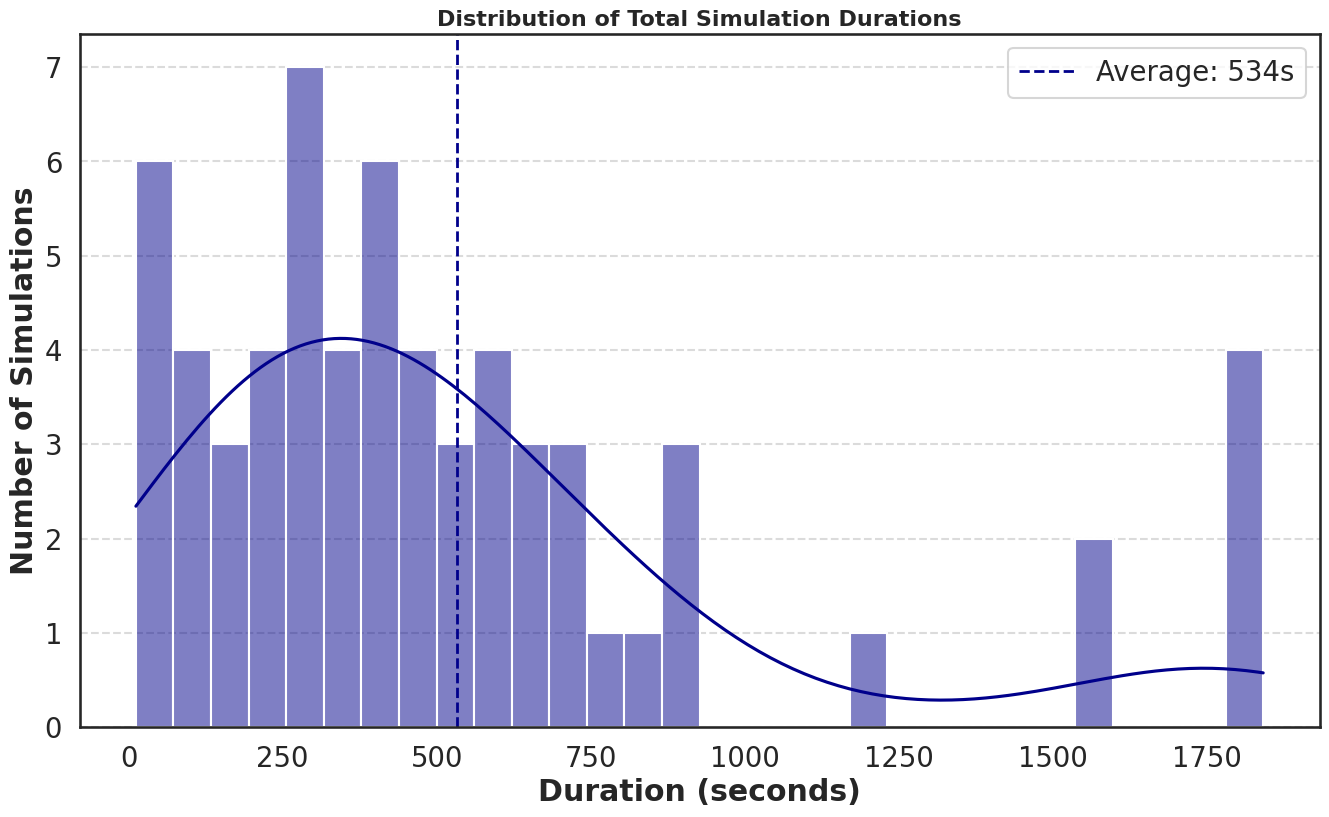


--- Summary Statistics ---


,duration_seconds
count,63.0
mean,533.746032
std,468.015576
min,12.0
25%,234.0
50%,417.0
75%,678.0
max,1841.0


In [19]:
# --- Step 1 (Corrected Again): Run the Query and Load the Data ---

# We will now use the correct column name wrapped in backticks.
query = """
WITH filtered AS (
  SELECT
    file_id,
    task,
    -- THIS IS THE CORRECTED LINE --
    TIME(`skill_start_time_hh:mm:ss`) AS skill_time
  FROM
    `sccm-discovery.AutoDoc.Annotations`
  WHERE
    task IN ('StartEx', 'ENDEX')
),

pivoted AS (
  SELECT
    file_id,
    MAX(CASE WHEN task = 'StartEx' THEN skill_time END) AS start_time,
    MAX(CASE WHEN task = 'ENDEX' THEN skill_time END) AS end_time
  FROM
    filtered
  GROUP BY
    file_id
)

SELECT
  file_id,
  start_time,
  end_time,
  TIME_DIFF(end_time, start_time, SECOND) AS duration_seconds
FROM
  pivoted
WHERE
  start_time IS NOT NULL AND end_time IS NOT NULL
"""

# Execute the query and load the result into a DataFrame
durations_df = client.query(query).to_dataframe()

print(f"Successfully calculated the duration for {len(durations_df)} simulations.")
print("Here's a preview of the data:")
display(durations_df.head())


# --- Step 2: Create the Histogram Visualization ---

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 9))

sns.set_style("white")
sns.despine()
sns.set_context("talk", font_scale=1.2)

# Create the histogram.
sns.histplot(data=durations_df, x='duration_seconds', bins=30, kde=True, color='darkblue')

# Add a vertical line at the average (mean) duration.
average_duration = durations_df['duration_seconds'].mean()
plt.axvline(average_duration, color='darkblue', linestyle='--', linewidth=2, label=f'Average: {average_duration:.0f}s')

# Add titles and labels.
plt.title('Distribution of Total Simulation Durations', fontsize=16)
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Simulations')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Step 3: Print some summary statistics ---
print("\n--- Summary Statistics ---")
display(durations_df['duration_seconds'].describe())

Successfully calculated the duration for 63 simulations.
Here's a preview of the data:


,file_id,start_time,end_time,duration_seconds
0,42,00:00:00,00:08:15,495
1,33,00:00:00,00:07:51,471
2,75,00:00:00,00:06:22,382
3,59,00:00:00,00:26:24,1584
4,28,00:00:00,00:00:52,52


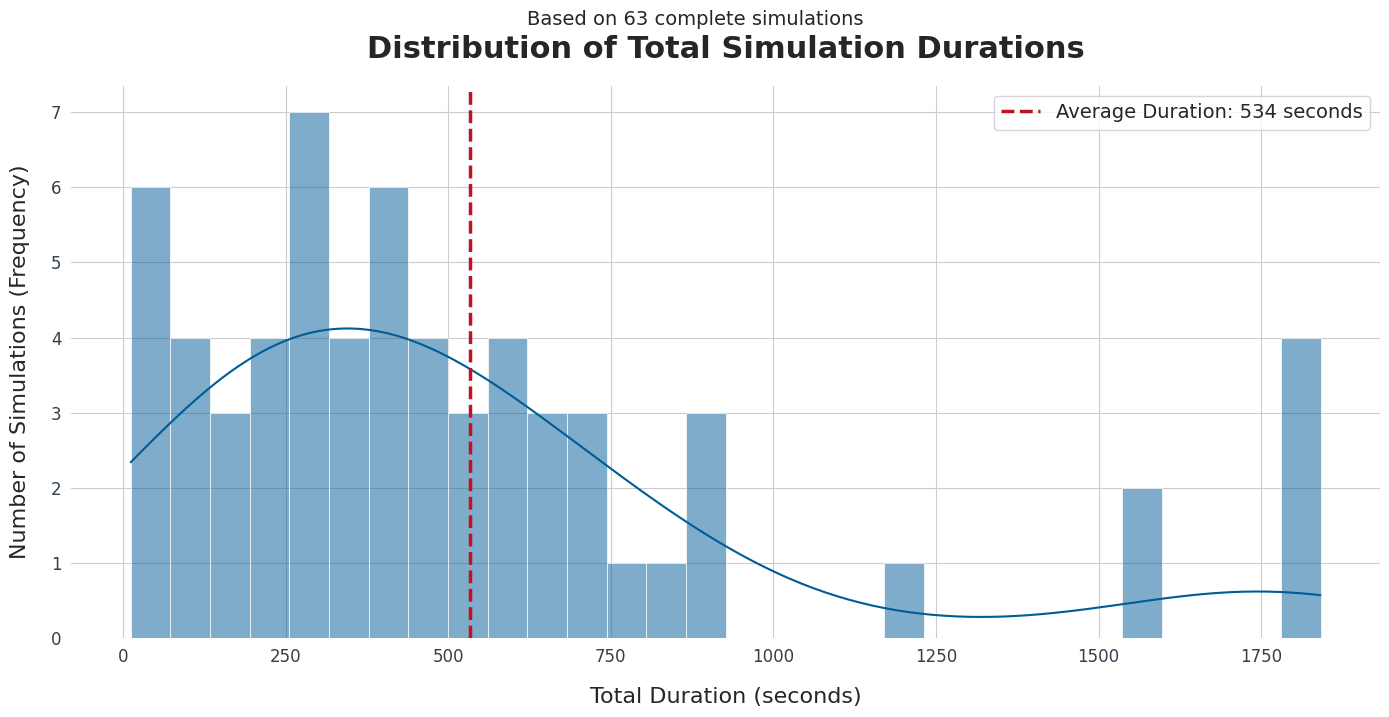


--- Summary Statistics ---


,duration_seconds
count,63.0
mean,533.746032
std,468.015576
min,12.0
25%,234.0
50%,417.0
75%,678.0
max,1841.0


In [3]:
# --- Step 1: Run the Query and Load the Data (This part is the same) ---

# We will now use the correct column name wrapped in backticks.
query = """
WITH filtered AS (
  SELECT
    file_id,
    task,
    TIME(`skill_start_time_hh:mm:ss`) AS skill_time
  FROM
    `sccm-discovery.AutoDoc.Annotations`
  WHERE
    task IN ('StartEx', 'ENDEX')
),

pivoted AS (
  SELECT
    file_id,
    MAX(CASE WHEN task = 'StartEx' THEN skill_time END) AS start_time,
    MAX(CASE WHEN task = 'ENDEX' THEN skill_time END) AS end_time
  FROM
    filtered
  GROUP BY
    file_id
)

SELECT
  file_id,
  start_time,
  end_time,
  TIME_DIFF(end_time, start_time, SECOND) AS duration_seconds
FROM
  pivoted
WHERE
  start_time IS NOT NULL AND end_time IS NOT NULL
"""

# Execute the query and load the result into a DataFrame
durations_df = client.query(query).to_dataframe()

print(f"Successfully calculated the duration for {len(durations_df)} simulations.")
print("Here's a preview of the data:")
display(durations_df.head())


# --- Step 2: Create the "Prettier" Histogram Visualization ---

import matplotlib.pyplot as plt
import seaborn as sns

# --- Style and Font Settings ---
sns.set_style("whitegrid") # Use a clean grid background
plt.rcParams['font.family'] = 'sans-serif' # Use a clean, modern font
plt.rcParams['axes.edgecolor'] = '#333F4B'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.color'] = '#333F4B'
plt.rcParams['ytick.color'] = '#333F4B'
# -----------------------------

# Create the figure
plt.figure(figsize=(14, 8))

# Create the histogram with improved aesthetics
sns.histplot(
    data=durations_df,
    x='duration_seconds',
    bins=30,
    kde=True,
    color='#005b96',  # A nice shade of blue
    edgecolor='white',
    linewidth=0.5
)

# Add a vertical line for the average duration
average_duration = durations_df['duration_seconds'].mean()
plt.axvline(
    average_duration,
    color='#c1121f',  # A strong red for contrast
    linestyle='--',
    linewidth=2.5,
    label=f'Average Duration: {average_duration:.0f} seconds'
)

# --- Add Titles and Labels with LARGER FONTS ---
plt.title(
    'Distribution of Total Simulation Durations',
    fontsize=22,
    fontweight='bold',
    pad=20  # Add some padding above the title
)
plt.suptitle(
    f'Based on {len(durations_df)} complete simulations',
    y=0.92, # Position the subtitle
    fontsize=14
)
plt.xlabel('Total Duration (seconds)', fontsize=16, labelpad=15)
plt.ylabel('Number of Simulations (Frequency)', fontsize=16, labelpad=15)

# --- Improve Ticks and Legend ---
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

# --- Clean up the final look ---
sns.despine(left=True, bottom=True) # Remove the top and right spines
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()


# --- Step 3: Print some summary statistics (Unchanged) ---
print("\n--- Summary Statistics ---")
display(durations_df['duration_seconds'].describe())

In [22]:
medical_tasks_df = annotations_df[
    ~annotations_df['task'].isin(['StartEx', 'Time Sync', 'ENDEX']) &
    annotations_df['task'].notna()
].copy()

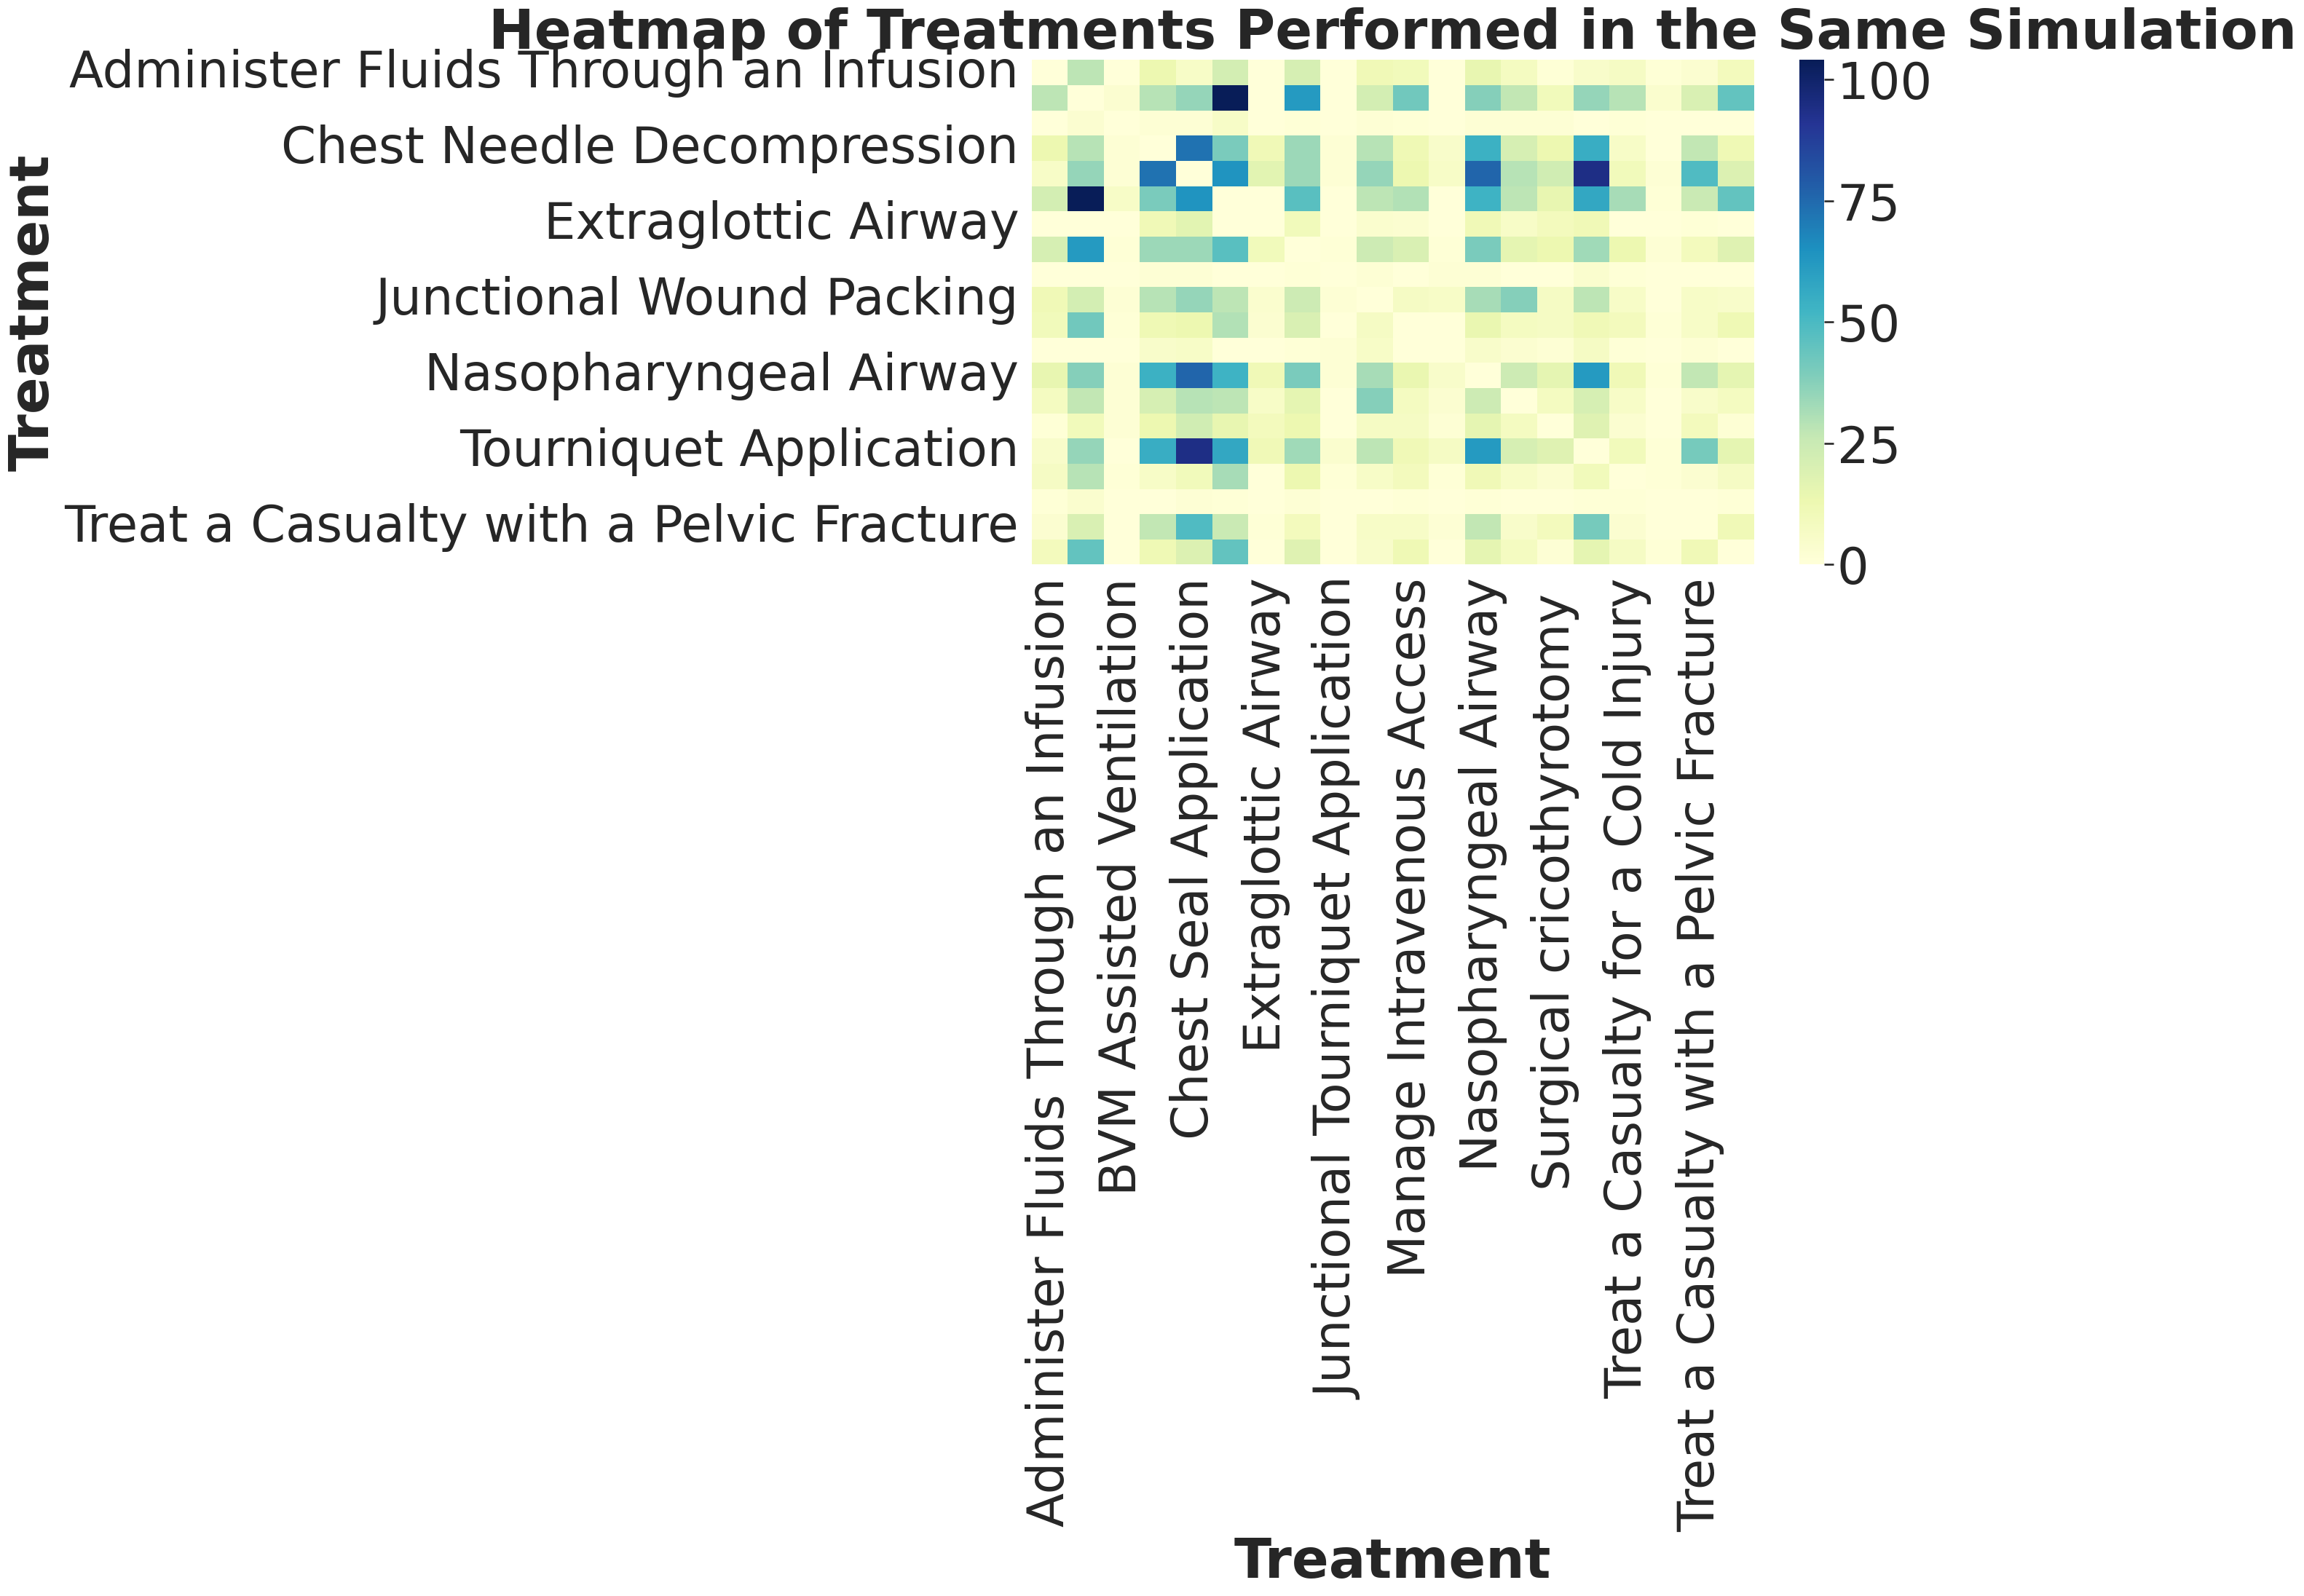

In [25]:
# --- Visualization 2: Task Co-occurrence Heatmap ---

# We'll use the 'medical_tasks_df' from the previous step.

# Create a crosstabulation. This counts how many times each pair of tasks appeared in the same file_id.
# We first get a list of tasks per file, then use crosstab.
df_pairs = medical_tasks_df.merge(medical_tasks_df, on='file_id')
# We only care about pairs of different tasks
df_pairs = df_pairs[df_pairs['task_x'] != df_pairs['task_y']]

# Create the co-occurrence matrix
co_occurrence_matrix = pd.crosstab(df_pairs['task_x'], df_pairs['task_y'])

# Create the heatmap
sns.set_context("talk", font_scale=3)
plt.figure(figsize=(16, 9))
sns.heatmap(co_occurrence_matrix, cmap='YlGnBu', annot=False) # 'annot=False' because the matrix is large

plt.title('Heatmap of Treatments Performed in the Same Simulation', )
plt.xlabel('Treatment', )
plt.ylabel('Treatment', )
plt.show()

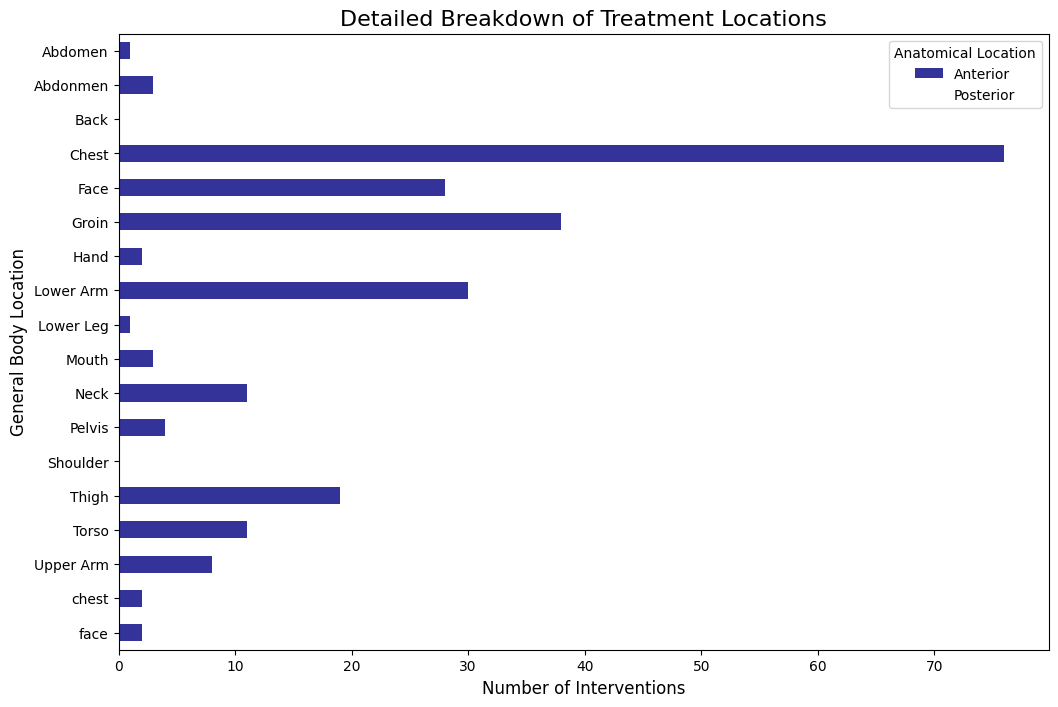

In [12]:
# --- Visualization 3: Detailed Injury Location ---

# Group by both body location and anatomical location and count the occurrences
detailed_location_counts = annotations_df.dropna(subset=['body_location', 'anatomical_location']) \
                                       .groupby(['body_location', 'anatomical_location']) \
                                       .size() \
                                       .unstack(fill_value=0)

# Create the stacked bar chart
detailed_location_counts.plot(kind='barh', stacked=True, figsize=(12, 8), colormap='terrain')

plt.title('Detailed Breakdown of Treatment Locations', fontsize=16)
plt.xlabel('Number of Interventions', fontsize=12)
plt.ylabel('General Body Location', fontsize=12)
plt.legend(title='Anatomical Location')
plt.gca().invert_yaxis() # Put the most frequent on top
plt.show()

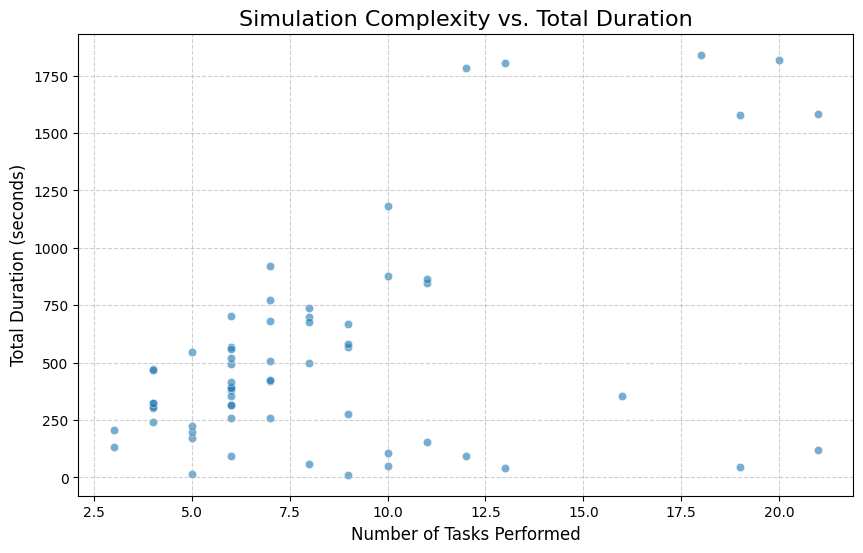

In [13]:
# --- Visualization 4: Complexity vs. Duration ---

# We can re-use the 'durations_df' from the histogram we made earlier.
# If you don't have it, uncomment and run the query again.
# durations_df = client.query(query).to_dataframe()

# Now, let's count the number of tasks in each simulation
task_counts_per_file = medical_tasks_df.groupby('file_id').size().reset_index(name='task_count')

# Merge the two dataframes together so we have duration and task count in one place
complexity_df = pd.merge(durations_df, task_counts_per_file, on='file_id')

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=complexity_df, x='task_count', y='duration_seconds', alpha=0.6)

plt.title('Simulation Complexity vs. Total Duration', fontsize=16)
plt.xlabel('Number of Tasks Performed', fontsize=12)
plt.ylabel('Total Duration (seconds)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()